## Simple Implementation of Binomial Option Pricing Model (Cox, Ross, Rubinstein 1979)

In [1]:
# Binomial Model 

import numpy as np
from numpy.polynomial import Polynomial



class BinomialModel:
    """Simple implementation of Binomial Model (Cox, Ross, Rubinstein 1979)
    for testing purposes."""

    def __init__(self, u, d, r, S0, T, n):
        self.u = u
        self.d = d
        self.r = r
        self.S0 = S0
        self.T = T
        self.n = n
        self.ST = np.array(list(self.terminal()), dtype="float64")

    def __repr__(self):
        return type(
            self
        ).__name__ + "(u={u}, d={d}, r={r}, S0={S0}, T={T}, n={n})".format_map(
            vars(self)
        )

    @property
    def dt(self):
        return self.T / self.n

    @property
    def q(self):
        return (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)

    def terminal(self):
        S0, u, d, n = self.S0, self.u, self.d, self.n
        for ups in range(n + 1):
            yield S0 * u**ups * d ** (n - ups)

    def evaluate(self, payoff):
        v = payoff(self.ST)
        q = self.q
        while len(v) > 1:
            v = v[1:] * q + v[:-1] * (1 - q)
        return v[0] * np.exp(-self.r * self.T)

    def evaluate_american_exercisable_iter(self, payoff):
        df = np.exp(-self.r * self.dt)
        continuation = payoff(self.ST)
        spot = self.ST
        q = self.q
        while len(continuation) > 1:
            continuation = df * (continuation[1:] * q + continuation[:-1] * (1 - q))
            spot = df * (spot[1:] * q + spot[:-1] * (1 - q))
            exercise = payoff(spot)
            optimal = np.maximum(continuation, exercise)
            yield continuation, spot, exercise, optimal
            continuation = optimal

    def evaluate_american_exercisable(self, payoff):
        for _, _, _, opt in self.evaluate_american_exercisable_iter(payoff):
            pass
        return opt[0]


def create_binomial_model(sigma, r, S0, T, n=10):
    u = np.exp(sigma * np.sqrt(T / n))
    return BinomialModel(u, 1 / u, r, S0, T, n)


def call_payoff(strike):
    return lambda S: np.maximum(S - strike, 0)


def put_payoff(strike):
    return lambda S: np.maximum(strike - S, 0)


def european_call_price(mdl, strike):
    return mdl.evaluate(call_payoff(strike))


def american_call_price(mdl, strike):
    return mdl.evaluate_american_exercisable(call_payoff(strike))


def european_put_price(mdl, strike):
    return mdl.evaluate(put_payoff(strike))


def american_put_price(mdl, strike):
    return mdl.evaluate_american_exercisable(put_payoff(strike))


def american_put_exercise_barrier(mdl, strike):
    exercises = []
    payoff = put_payoff(strike)
    for cnt, s, ex, opt in mdl.evaluate_american_exercisable_iter(payoff):
        ex_idx = (ex >= cnt) & (ex > 0)
        ex_spots = s[ex_idx]
        exercises.append(ex_spots.max() if ex_idx.any() else np.nan)
    exercises.reverse()
    return np.array(exercises)


def american_put_exercise_barrier_fitted(mdl, strike, degree=4):
    barrier = american_put_exercise_barrier(mdl, strike)
    t = np.linspace(0, mdl.T, mdl.n)
    ex_exists = ~np.isnan(barrier)
    return Polynomial.fit(t[ex_exists], barrier[ex_exists], degree)

766386.6573592064

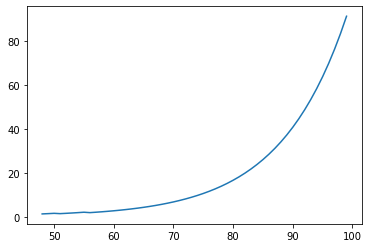

In [3]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from ipywidgets import interact

mdl = create_binomial_model(sigma=0.4, r=1e-14, S0=100, T=5, n=100)
exercise_barrier = american_put_exercise_barrier(mdl, 100)
plt.plot(exercise_barrier)
mdl.ST.max()

In [7]:
# @interact(r=(-0.02, 0.1, 0.000000001))
# def p(r=0.00000000000001):
#     mdl = create_binomial_model(sigma=0.4, r=r, S0=100, T=5, n=10)
#     print(american_put_price(mdl, 100))
#     exercise_barrier = american_put_exercise_barrier(mdl, 100)
#     plt.plot(exercise_barrier)

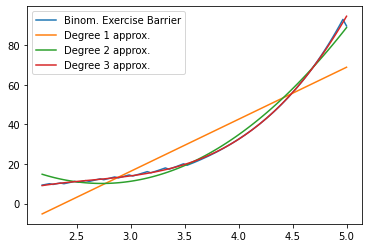

In [11]:

n = 150
mdl = create_binomial_model(sigma=0.2, r=1e-14, S0=100, T=5, n=n)
exercise_barrier = american_put_exercise_barrier(mdl, 100)
tau = np.linspace(0, 5, n)
ex_exists = ~np.isnan(exercise_barrier)
fitted = Polynomial.fit(tau[ex_exists], exercise_barrier[ex_exists], 2)


exercise_barrier = american_put_exercise_barrier(mdl, 100)
tau = np.linspace(0, 5, n)
ex_exists = ~np.isnan(exercise_barrier)
plt.plot(tau, exercise_barrier)
for i in range(1, 4):
    b = american_put_exercise_barrier_fitted(mdl, 100, i)
    plt.plot(*b.linspace())
plt.legend(
    [
        "Binom. Exercise Barrier",
        "Degree 1 approx.",
        "Degree 2 approx.",
        "Degree 3 approx.",
    ]
);